## A Guide to Time Series Forecasting with Prophet

### Load Data

In [82]:
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [83]:
df = pd.read_excel("superstore.xls")

furniture = df.loc[df['Category'] == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [84]:
# drop unwanted columns

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 
        'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
        'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


The Prophet library expects as input a DataFrame with one column containing the time information, and another column containing the metric that we wish to forecast. Importantly, the time column is expected to be of the datetime type, so let’s check the type of our columns

In [85]:
furniture.dtypes

Order Date    datetime64[ns]
Sales                float64
dtype: object

Prophet also imposes the strict condition that the input columns be named ds (the time column) and y (the metric column), so let’s rename the columns in our DataFrame.

In [86]:
furniture = furniture.rename(columns={'Order Date': 'ds',
                        'Sales': 'y'})
furniture.tail()

,ds,y
7636,2017-12-29,258.750
7632,2017-12-29,1207.840
5131,2017-12-29,101.120
7635,2017-12-29,300.980
906,2017-12-30,323.136


In [87]:
# predict on the monthly level

furniture = furniture.groupby('ds')['y'].sum().reset_index()
furniture.set_index('ds', inplace=True)
furniture = furniture['y'].resample('MS').mean()

furniture = pd.DataFrame({'ds': furniture.index, 'y': furniture.values})
furniture.head()

,ds,y
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


It is good practice to visualize the data we are going to be working with, so let’s plot our time series:

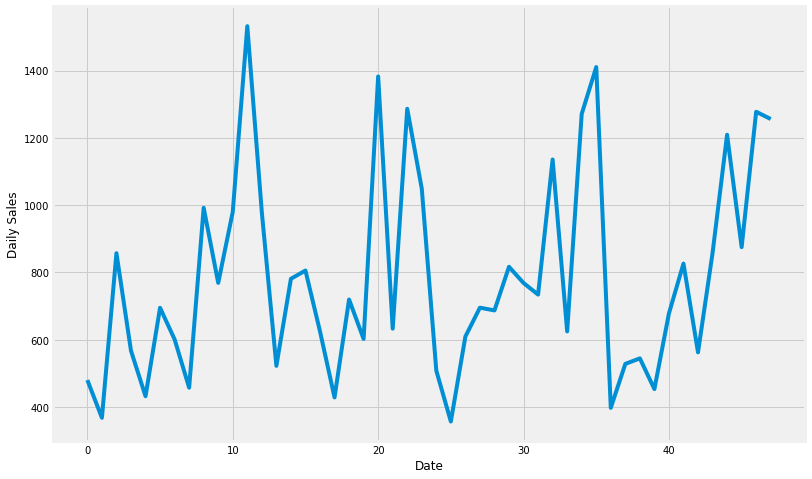

In [88]:
ax = furniture['y'].plot(figsize=(12, 8))
ax.set_ylabel('Daily Sales')
ax.set_xlabel('Date')
plt.show()

### Forecasting with Prophet

In this section, we will describe how to use the Prophet library to predict future values of our time series. To begin, we must instantiate a new Prophet object. Prophet enables us to specify a number of arguments. For example, we can specify the desired range of our uncertainty interval by setting the interval_width parameter.

In [89]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

my_model = Prophet(interval_width=0.95)

Now that our Prophet model has been initialized, we can call its fit method with our DataFrame as input.

In [90]:
my_model.fit(furniture)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In order to obtain forecasts of our time series, we must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions. 

Conveniently, we do not have to concern ourselves with manually creating this DataFrame, as Prophet provides the make_future_dataframe helper function:

In [91]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
79,2020-08-01
80,2020-09-01
81,2020-10-01
82,2020-11-01
83,2020-12-01


In the code chunk above, we instructed Prophet to generate 36 datestamps in the future. When working with Prophet, it is important to consider the frequency of our time series. Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, MS is the start of the month).

The DataFrame of future dates is then used as input to the predict method of our fitted model.

In [92]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
79,2020-08-01,796.158946,552.190585,1042.960690
80,2020-09-01,1121.743197,866.138143,1375.241557
81,2020-10-01,776.426952,535.590029,1008.320881
82,2020-11-01,1303.002320,1071.396717,1532.591583
83,2020-12-01,1515.791776,1264.463539,1752.742399


Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:
- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts

A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.

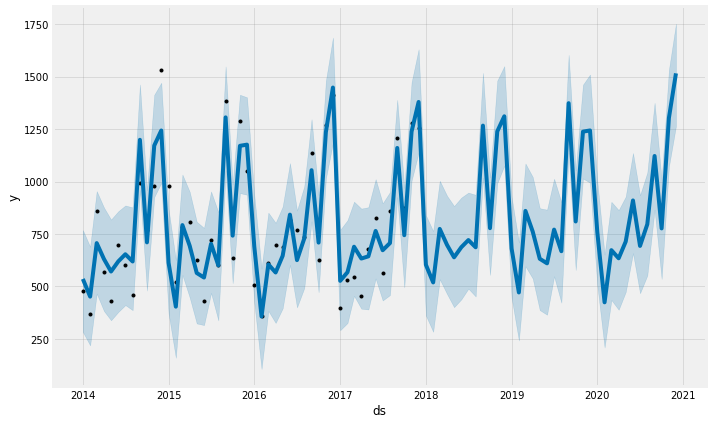

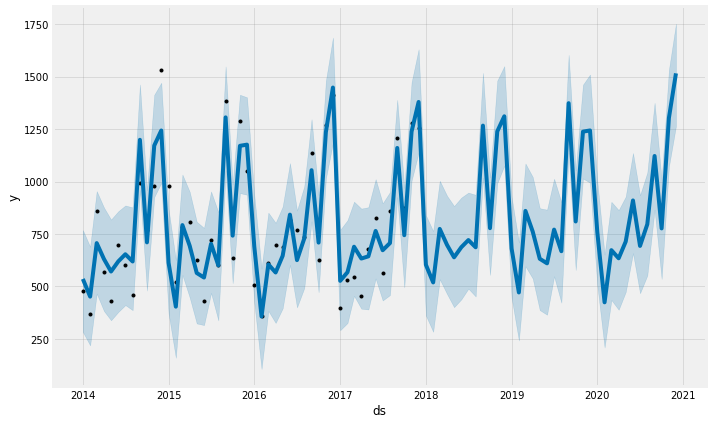

In [94]:
my_model.plot(forecast, uncertainty=True)

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

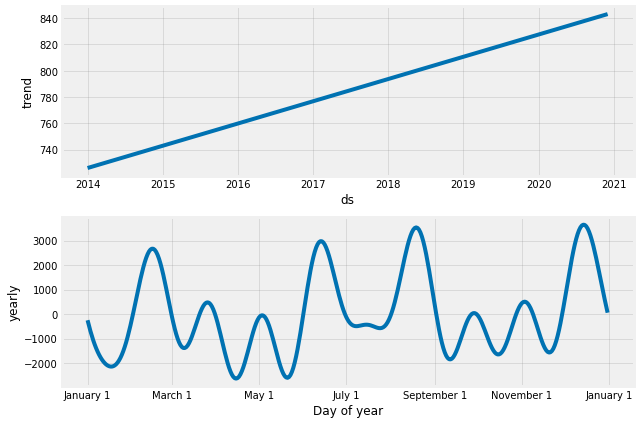

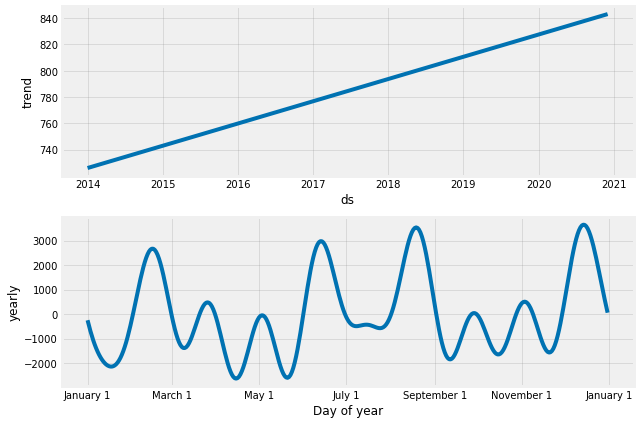

In [95]:
my_model.plot_components(forecast)